# Bert with tweet_eval
fine tune a bert model with tweet_eval for sentiment classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install ktrain on Google Colab
!pip3 install ktrain

In [ ]:
# install datasets on Google Colab
!pip3 install datasets

In [26]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import random
import ktrain
from ktrain import text

import time

import matplotlib.pyplot as plt


## 1. Import data

In [28]:
# download dataset from hungging face
dataset = load_dataset("tweet_eval", "sentiment")
dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [29]:
data_train = pd.DataFrame(dataset['train'])
data_test = pd.DataFrame(dataset['test'])

print(data_train)
print(data_test)

                                                    text  label
0      "QT @user In the original draft of the 7th boo...      2
1      "Ben Smith / Smith (concussion) remains out of...      1
2      Sorry bout the stream last night I crashed out...      1
3      Chase Headley's RBI double in the 8th inning o...      1
4      @user Alciato: Bee will invest 150 million in ...      2
...                                                  ...    ...
45610  @user \""So amazing to have the beautiful Lady...      2
45611  9 September has arrived, which means Apple's n...      2
45612  Leeds 1-1 Sheff Wed. Giuseppe Bellusci securin...      2
45613  @user no I'm in hilton head till the 8th lol g...      1
45614  WASHINGTON (Reuters) - U.S. Vice President Joe...      1

[45615 rows x 2 columns]
                                                    text  label
0      @user @user what do these '1/2 naked pics' hav...      1
1      OH: “I had a blue penis while I was this” [pla...      1
2      @user @

In [33]:
# Balance the amount of each class
SEED = 66

num_train_per_class = 2000
num_test_per_class = 500
balanced_train_data = data_train.groupby('label', group_keys=False).apply(lambda x:\
        x.sample(min(len(x), num_train_per_class), random_state=SEED)).sample(frac=1, random_state=SEED)
balanced_test_data = data_test.groupby('label', group_keys=False).apply(lambda x:\
        x.sample(min(len(x), num_test_per_class), random_state=SEED)).sample(frac=1, random_state=SEED)

X_train = balanced_train_data.text.tolist()
X_test = balanced_test_data.text.tolist()

Y_train = balanced_train_data.label.tolist()
Y_test = balanced_test_data.label.tolist()

data = balanced_train_data.append(balanced_test_data, ignore_index=True)

class_names = ['negtive', 'neutral', 'positive']

print('size of training set: %s' % (len(balanced_train_data['text'])))
print('size of validation set: %s' % (len(balanced_test_data['text'])))
print(data.label.value_counts())

data.head(10)

size of training set: 6000
size of validation set: 1500
0    2500
2    2500
1    2500
Name: label, dtype: int64


,text,label
0,Movie idea: Blade VS Twilight Besides fire and...,0
1,@user - Just watched the Klitschko fight from ...,0
2,Took the day off work and treated babe to some...,2
3,Thank GOD we don't have to wait 'til 7 pm tomo...,2
4,Ben Howland implies he has no interest in #Hus...,0
5,@user @user either way its probably true rmbr ...,1
6,In my 1st day in office I plan 2 pass a Bill 4...,1
7,Happy Thursday and Happy National Hot Dog Day ...,2
8,Remember this coming Sunday November 4th Dayli...,1
9,I wish Nicki would have flew across the stage ...,0


## 2. Data preprocessing
* The text must be preprocessed in a specific way for use with BERT. This is accomplished by setting preprocess_mode to ‘bert’. The BERT model and vocabulary will be automatically downloaded

* BERT can handle a maximum length of 512, but let's use less to reduce memory and improve speed.

In [34]:
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=Y_train,
                                        x_test=X_test, y_test=Y_test,
                                        class_names=class_names,
                                        preprocess_mode='bert',
                                        maxlen=350,
                                        max_features=35000)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


## 3. Training and validation
Load the pretrained BERT

In [35]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 350


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [36]:
# wrap it in learner object
learner = ktrain.get_learner(model, train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6)

In [37]:
# find the proper learning rate, but it needs time
# learner.lr_find()

learner.fit_onecycle(2e-5, 5)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
1000/1000 [==============================] - 619s 600ms/step - loss: 0.8144 - accuracy: 0.6277 - val_loss: 0.6904 - val_accuracy: 0.6907
Epoch 2/5
1000/1000 [==============================] - 556s 556ms/step - loss: 0.5649 - accuracy: 0.7662 - val_loss: 0.7577 - val_accuracy: 0.6647
Epoch 3/5
1000/1000 [==============================] - 595s 595ms/step - loss: 0.3432 - accuracy: 0.8685 - val_loss: 0.9018 - val_accuracy: 0.6880
Epoch 4/5
1000/1000 [==============================] - 556s 555ms/step - loss: 0.1463 - accuracy: 0.9518 - val_loss: 1.0453 - val_accuracy: 0.6853
Epoch 5/5
1000/1000 [==============================] - 556s 556ms/step - loss: 0.0436 - accuracy: 0.9885 - val_loss: 1.3374 - val_accuracy: 0.6787


In [38]:
# collect historical data during the training process
history = learner.history

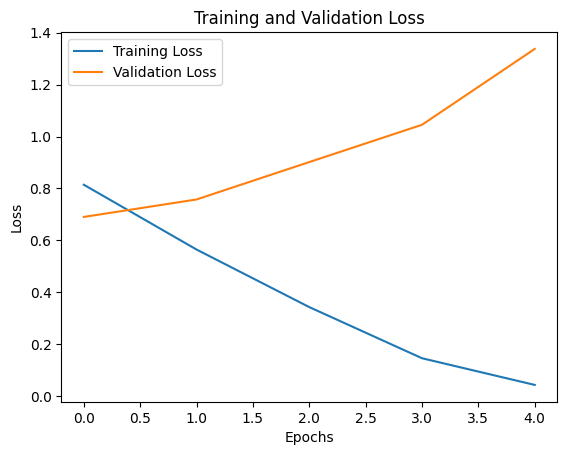

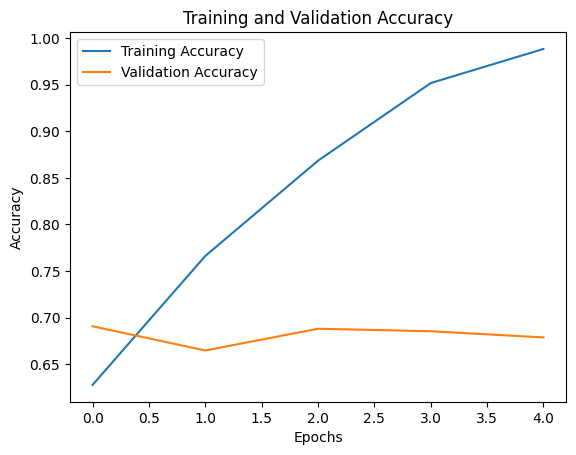

In [39]:
# Draw Loss function curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Draw accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Test with other inputs

In [40]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

['negtive', 'neutral', 'positive']

In [41]:
message = 'I just broke up with my boyfriend'
# message = 'How would you feel if I gave you your copy in person?'

start_time = time.time()
prediction = predictor.predict(message)

print('predicted: {} ({:.2f})'.format(prediction, (time.time() - start_time)))

predicted: negtive (6.00)


## 4. Saving Bert Model

In [42]:
predictor.save("/content/drive/MyDrive/Project/bert_tweet/model")

ValueError: ignored